In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import math
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, \
                  array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
import seaborn as sns
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import sklearn
from sklearn.decomposition import PCA
import itertools
import mdtraj as md


This is a 125 microsecond trajectory of fast folding variant of the Villin Headpiece generated from DEShaw Research:

https://www.science.org/doi/full/10.1126/science.1208351

It can be compared to an X-ray structure:
https://www.rcsb.org/structure/2F4K
(Note that the x-ray structure has multiple positions for some sidechain atoms)

You can download the required files here:
https://www.dropbox.com/s/60jxmiuvlyehbhz/Villin_Lab.zip?dl=0

In [2]:
pdb=f'{os.getcwd()}/Villin_Lab/2F4K.protein.pdb'
trajectory=f'{os.getcwd()}/Villin_Lab/2F4K.protein.s10.dcd'
xray_CA_pdb=f'{os.getcwd()}/Villin_Lab/2f4K.xray.CA.pdb'
outdir=f'{os.getcwd()}/output'
if not os.path.exists('outdir'):
    os.makedirs('outdir')
    
print("outdir:",outdir)
print("pdb:",pdb)
print("trjaectory:",trajectory)



outdir: C:\Users\f004q29\Documents\School\PhD\Fourth Year\CHEM101_6\Exercise_4/output
pdb: C:\Users\f004q29\Documents\School\PhD\Fourth Year\CHEM101_6\Exercise_4/Villin_Lab/2F4K.protein.pdb
trjaectory: C:\Users\f004q29\Documents\School\PhD\Fourth Year\CHEM101_6\Exercise_4/Villin_Lab/2F4K.protein.s10.dcd


In [3]:
stride_sel=10
trj = md.load(trajectory, top=pdb,stride=stride_sel)
trj.center_coordinates()
top = trj.topology
first_frame = 0
last_frame = trj.n_frames
n_frames=trj.n_frames
trj_length=125
time=np.linspace(0,125,n_frames)

In [4]:
nres=[]
for res in trj.topology.residues: nres.append(res.resSeq)
sequence=(' %s' % [residue for residue in trj.topology.residues])
resname=(' %s' % [residue.name for residue in trj.topology.residues])
resindex=(' %s' % [residue.index for residue in trj.topology.residues])
res_num=(' %s' % [residue.resSeq  for residue in trj.topology.residues])



#log = open("/Users/paulrobustelli/Desktop/Sa_calc.log", "w")
print("** SYSTEM INFO **\n")
print("Number of atoms: %d\n" % trj.n_atoms)
print("Number of residues: %d\n" % len(set(nres)))
print("Number of frames: %d\n" % trj.n_frames)
print("Starting frame: %d\n" % first_frame)
print("Last frame: %d\n" % last_frame)
print("sequence: %s\n" % sequence)
print("residue names: %s\n" % resname)
print("residue number: %s\n" % res_num)
print("residue index: %s\n" % resindex)


** SYSTEM INFO **

Number of atoms: 577

Number of residues: 35

Number of frames: 6280

Starting frame: 0

Last frame: 6280

sequence:  [LEU42, SER43, ASP44, GLU45, ASP46, PHE47, LYS48, ALA49, VAL50, PHE51, GLY52, MET53, THR54, ARG55, SER56, ALA57, PHE58, ALA59, ASN60, LEU61, PRO62, LEU63, TRP64, NLE65, GLN66, GLN67, HIS68, LEU69, NLE70, LYS71, GLU72, LYS73, GLY74, LEU75, PHE76, LEU42, SER43, ASP44, GLU45, ASP46, PHE47, LYS48, ALA49, VAL50, PHE51, GLY52, MET53, THR54, ARG55, SER56, ALA57, PHE58, ALA59, ASN60, LEU61, PRO62, LEU63, TRP64, NLE65, GLN66, GLN67, HIS68, LEU69, NLE70, LYS71, GLU72, LYS73, GLY74, LEU75, PHE76]

residue names:  ['LEU', 'SER', 'ASP', 'GLU', 'ASP', 'PHE', 'LYS', 'ALA', 'VAL', 'PHE', 'GLY', 'MET', 'THR', 'ARG', 'SER', 'ALA', 'PHE', 'ALA', 'ASN', 'LEU', 'PRO', 'LEU', 'TRP', 'NLE', 'GLN', 'GLN', 'HIS', 'LEU', 'NLE', 'LYS', 'GLU', 'LYS', 'GLY', 'LEU', 'PHE', 'LEU', 'SER', 'ASP', 'GLU', 'ASP', 'PHE', 'LYS', 'ALA', 'VAL', 'PHE', 'GLY', 'MET', 'THR', 'ARG', 'SER', 'ALA

In [5]:
residue_num=[]
for res in top.residues: 
    residue_num.append(res.resSeq)
residue_id=np.asarray(residue_num)


In [6]:
xray_CA = md.load_pdb(xray_CA_pdb)
top_xray = xray_CA.topology
top_xray
residue_xray=[]
for res in top_xray.residues: 
    residue_xray.append(res.resSeq)
resid_xray=np.asarray(residue_xray)
resid_xray

array([42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58,
       59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75,
       76])

In [7]:
#Use DSSP to calculate the secondary structure definition
#https://mdtraj.org/1.9.4/api/generated/mdtraj.compute_dssp.html
trjBB = md.load(trajectory, top=pdb,stride=stride_sel)
BB=top.select("backbone")
trjBB.restrict_atoms(BB)
trjBB.center_coordinates()

dssp=md.compute_dssp(trjBB,simplified=True)


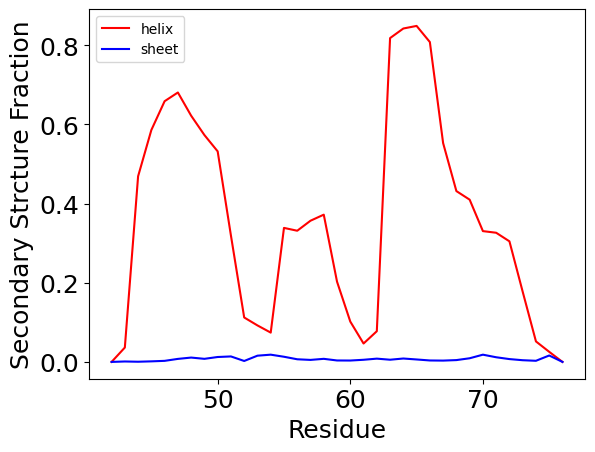

In [8]:
#dssp=md.compute_dssp(trj,simplified=True)

def dssp_convert(dssp):
 dsspH=np.copy(dssp)
 dsspE=np.copy(dssp)
 dsspH[dsspH=='H']=1                                                                                      
 dsspH[dsspH=='E']=0                                                                                      
 dsspH[dsspH=='C']=0                                                                                      
 dsspH[dsspH=='NA']=0 
 dsspH=dsspH.astype(int)
 TotalH=np.sum(dsspH,axis=1) 
 Hprop=np.sum(dsspH,axis=0).astype(float)/len(dsspE) 

 dsspE[dsspE=='H']=0
 dsspE[dsspE=='E']=1
 dsspE[dsspE=='C']=0
 dsspE[dsspE=='NA']=0
 dsspE=dsspE.astype(int)
 TotalE=np.sum(dsspE,axis=1) 
 Eprop=np.sum(dsspE,axis=0).astype(float)/len(dsspE) 
 return Hprop, Eprop

Hprop,Eprop=dssp_convert(dssp)
plt.plot(resid_xray,Hprop,c='r',label='helix')
plt.plot(resid_xray,Eprop,c='b',label='sheet')

plt.legend(loc="upper left")
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Strcture Fraction', size=18)
plt.tick_params(labelsize=18)


In [9]:
indices_phi, phis = md.compute_phi(trj)
indices_psi, psis = md.compute_psi(trj)
indices_chi1, chi1s = md.compute_chi1(trj)
indices_chi2, chi2s = md.compute_chi2(trj)

In [10]:
phi_dict={}
dihedral_dict = { 'phi': { },
          'psi': { },
          'chi1': { },
          'chi2': { }}

for i in range(0,len(indices_phi)):
  indices=indices_phi[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['phi'][resnum]=phis[:,i]

for i in range(0,len(indices_psi)):
  indices=indices_psi[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['psi'][resnum]=psis[:,i]

for i in range(0,len(indices_chi1)):
  indices=indices_chi1[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['chi1'][resnum]=chi1s[:,i]

for i in range(0,len(indices_chi2)):
  indices=indices_chi2[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['chi2'][resnum]=chi2s[:,i]

In [11]:
#Heres a function to plot a phi/psi ramachandran plot:

def plot_phipsi(res):
 plt.hist2d(dihedral_dict['phi'][res],dihedral_dict['psi'][res],bins=36,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='jet')
 plt.xlabel('$\phi$', size=18)
 plt.ylabel('$\psi$', size=18)
 plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.tick_params(labelsize=18)
 plt.show()
 return

def plot_chi(res):
    if res in dihedral_dict['chi1']:
     plt.hist(dihedral_dict['chi1'][res],bins=36,range=[-3.14,3.14])        
     plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.xlabel('$\chi_1$', size=18)
     plt.ylabel('counts', size=18)
     plt.tick_params(labelsize=18)
     plt.show()
     plt.clf()   
    if res in dihedral_dict['chi2']:
     plt.hist2d(dihedral_dict['chi1'][res],dihedral_dict['chi2'][res],bins=36,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='jet')
     plt.xlabel('$\chi_1$', size=18)
     plt.ylabel('$\chi_2$', size=18)
     plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.tick_params(labelsize=18)
     plt.show()
    return




<>:5: SyntaxWarning: invalid escape sequence '\p'
<>:6: SyntaxWarning: invalid escape sequence '\p'
<>:17: SyntaxWarning: invalid escape sequence '\c'
<>:24: SyntaxWarning: invalid escape sequence '\c'
<>:25: SyntaxWarning: invalid escape sequence '\c'
<>:5: SyntaxWarning: invalid escape sequence '\p'
<>:6: SyntaxWarning: invalid escape sequence '\p'
<>:17: SyntaxWarning: invalid escape sequence '\c'
<>:24: SyntaxWarning: invalid escape sequence '\c'
<>:25: SyntaxWarning: invalid escape sequence '\c'
C:\Users\f004q29\AppData\Local\Temp\ipykernel_13936\399539292.py:5: SyntaxWarning: invalid escape sequence '\p'
  plt.xlabel('$\phi$', size=18)
C:\Users\f004q29\AppData\Local\Temp\ipykernel_13936\399539292.py:6: SyntaxWarning: invalid escape sequence '\p'
  plt.ylabel('$\psi$', size=18)
C:\Users\f004q29\AppData\Local\Temp\ipykernel_13936\399539292.py:17: SyntaxWarning: invalid escape sequence '\c'
  plt.xlabel('$\chi_1$', size=18)
C:\Users\f004q29\AppData\Local\Temp\ipykernel_13936\3995392

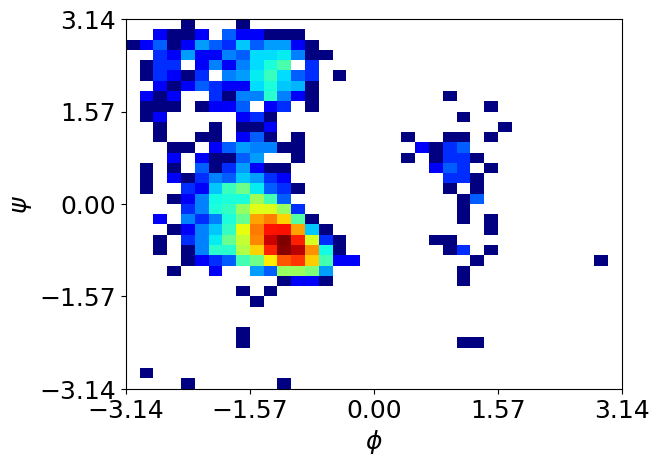

In [12]:
plot_phipsi(66)


<>:13: SyntaxWarning: invalid escape sequence '\p'
<>:14: SyntaxWarning: invalid escape sequence '\p'
<>:13: SyntaxWarning: invalid escape sequence '\p'
<>:14: SyntaxWarning: invalid escape sequence '\p'
C:\Users\f004q29\AppData\Local\Temp\ipykernel_13936\3914750776.py:13: SyntaxWarning: invalid escape sequence '\p'
  plt.xlabel('$\phi$', size=18)
C:\Users\f004q29\AppData\Local\Temp\ipykernel_13936\3914750776.py:14: SyntaxWarning: invalid escape sequence '\p'
  plt.ylabel('$\psi$', size=18)


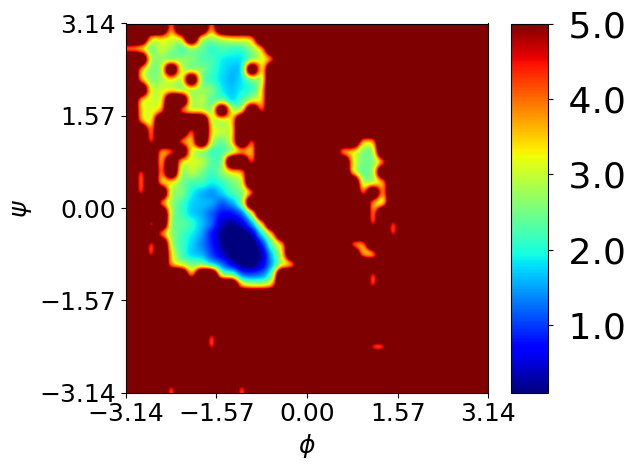

In [13]:
def plot_phipsi_FES(res):
 free_energy,xedges,yedges=np.histogram2d(dihedral_dict['psi'][res],dihedral_dict['phi'][res],36,[[-3.14,3.14],[-3.14,3.14]],density=True,weights=None)
 free_energy=np.log(np.flipud(free_energy)+.000001)
 T=300                                                                                                  
 kbT=T*0.008314/4.184 # kT in kcal/mol
 dG=-(kbT)*free_energy #Convert to kcal/mol
 im=plt.imshow(dG, interpolation='gaussian',extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],cmap='jet',aspect='auto')
 cbar_ticks=[0,1,2,3,4,5]
 cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'), aspect=10) # grab the Colorbar instance
 imaxes = plt.gca()                                                                                                 
 plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.xlabel('$\phi$', size=18)
 plt.ylabel('$\psi$', size=18)
 plt.tick_params(labelsize=18)
 plt.axes(cb.ax)
 plt.clim(vmin=0.1,vmax=5.0)
 plt.yticks(size='26')
 plt.tight_layout()
 plt.show()
 return

plot_phipsi_FES(66)

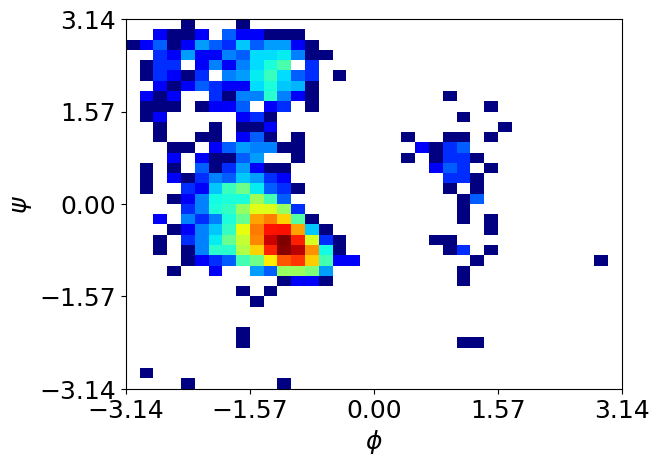

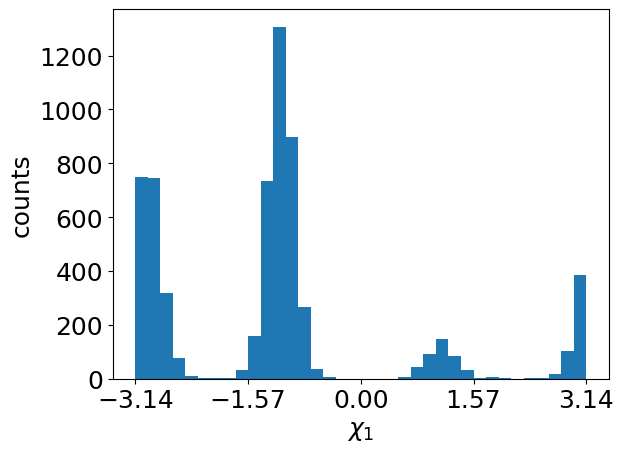

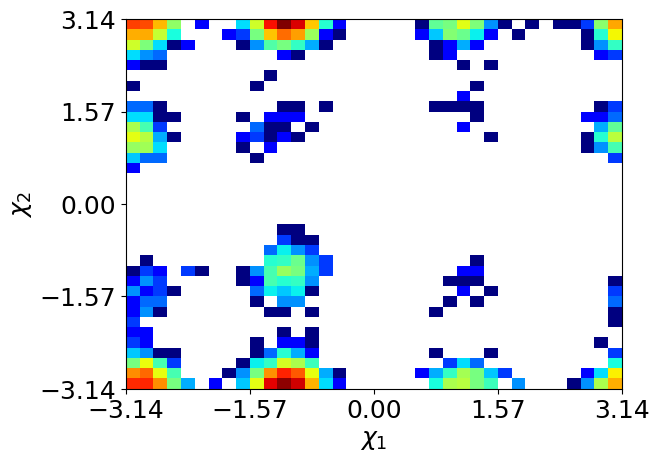

In [14]:
plot_phipsi(66)
plt.clf()
plot_chi(66)

In [15]:
#Heres a function to plot a phi/psi ramachandran plot:

def plot_phipsi_frames(res,frames):
 plt.hist2d(dihedral_dict['phi'][res][frames],dihedral_dict['psi'][res][frames],bins=36,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='jet')
 plt.xlabel('$\phi$', size=18)
 plt.ylabel('$\psi$', size=18)
 plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.tick_params(labelsize=18)
 plt.show()
 return

def plot_chi_frames(res,frames):
    if res in dihedral_dict['chi1']:
     plt.hist(dihedral_dict['chi1'][res][frames],bins=36,range=[-3.14,3.14])        
     plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.xlabel('$\chi_1$', size=18)
     plt.ylabel('counts', size=18)
     plt.tick_params(labelsize=18)
     plt.show()
     plt.clf()   
    if res in dihedral_dict['chi2']:
     plt.hist2d(dihedral_dict['chi1'][res][frames],dihedral_dict['chi2'][res][frames],bins=36,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='jet')
     plt.xlabel('$\chi_1$', size=18)
     plt.ylabel('$\chi_2$', size=18)
     plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.tick_params(labelsize=18)
     plt.show()
    return

<>:5: SyntaxWarning: invalid escape sequence '\p'
<>:6: SyntaxWarning: invalid escape sequence '\p'
<>:17: SyntaxWarning: invalid escape sequence '\c'
<>:24: SyntaxWarning: invalid escape sequence '\c'
<>:25: SyntaxWarning: invalid escape sequence '\c'
<>:5: SyntaxWarning: invalid escape sequence '\p'
<>:6: SyntaxWarning: invalid escape sequence '\p'
<>:17: SyntaxWarning: invalid escape sequence '\c'
<>:24: SyntaxWarning: invalid escape sequence '\c'
<>:25: SyntaxWarning: invalid escape sequence '\c'
C:\Users\f004q29\AppData\Local\Temp\ipykernel_13936\1508048848.py:5: SyntaxWarning: invalid escape sequence '\p'
  plt.xlabel('$\phi$', size=18)
C:\Users\f004q29\AppData\Local\Temp\ipykernel_13936\1508048848.py:6: SyntaxWarning: invalid escape sequence '\p'
  plt.ylabel('$\psi$', size=18)
C:\Users\f004q29\AppData\Local\Temp\ipykernel_13936\1508048848.py:17: SyntaxWarning: invalid escape sequence '\c'
  plt.xlabel('$\chi_1$', size=18)
C:\Users\f004q29\AppData\Local\Temp\ipykernel_13936\1508

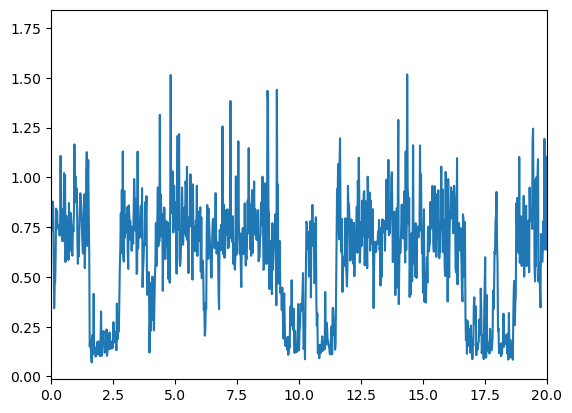

(array([ 84., 282., 283., 191., 139., 105.,  92.,  98., 108.,  92., 105.,
        140., 126., 176., 254., 274., 386., 381., 439., 438., 378., 359.,
        324., 238., 180., 149.,  99.,  90.,  52.,  42.,  32.,  32.,  22.,
         17.,  19.,  10.,   9.,   9.,   9.,   1.,   6.,   1.,   4.,   3.,
          1.,   0.,   0.,   0.,   0.,   1.]),
 array([0.07021478, 0.10396621, 0.13771763, 0.17146906, 0.20522049,
        0.23897193, 0.27272335, 0.30647478, 0.3402262 , 0.37397766,
        0.40772909, 0.44148052, 0.47523195, 0.50898337, 0.5427348 ,
        0.57648623, 0.61023766, 0.64398909, 0.67774051, 0.71149194,
        0.74524337, 0.7789948 , 0.81274623, 0.84649765, 0.88024908,
        0.91400051, 0.94775194, 0.98150337, 1.01525486, 1.04900622,
        1.08275771, 1.11650908, 1.15026057, 1.18401194, 1.21776342,
        1.25151479, 1.28526628, 1.31901765, 1.35276914, 1.3865205 ,
        1.42027199, 1.45402336, 1.48777485, 1.52152622, 1.55527771,
        1.58902907, 1.62278056, 1.65653193, 1.

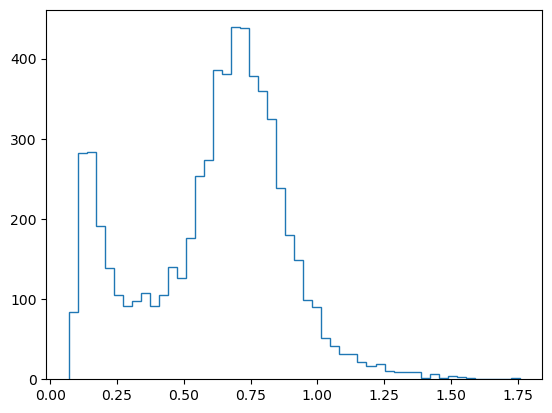

In [16]:
trjCA = md.load(trajectory, top=pdb,stride=stride_sel)
CA=top.select("name CA")
trjCA.restrict_atoms(CA)
trjCA.center_coordinates()

#CA_trj_sel=trj.topology.select("name CA")
#CA_xray_sel=xray_CA.topology.select("name CA")
rmsd = md.rmsd(trjCA,xray_CA)
plt.plot(time,rmsd)
plt.xlim(0,20)
plt.show()
plt.clf()

plt.hist(rmsd,histtype='step',bins=50)

In [17]:
native_frames=np.where(rmsd<0.25)[0]
unfolded_frames=np.where(rmsd>0.60)[0]

In [18]:
xray_CA = md.load_pdb(xray_CA_pdb)
top_xray = xray_CA.topology
top_xray
residue_xray=[]
for res in top.residues: 
    residue_xray.append(res.resSeq)
resid_xray=np.asarray(residue_xray)
resid_xray

array([42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58,
       59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75,
       76, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,
       58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74,
       75, 76])

In [19]:
trjCA = md.load(trajectory, top=pdb,stride=stride_sel)
CA=top.select("name CA")
trjCA.restrict_atoms(CA)
trjCA.center_coordinates()

<mdtraj.Trajectory with 6280 frames, 35 atoms, 35 residues, and unitcells at 0x162b3879940>

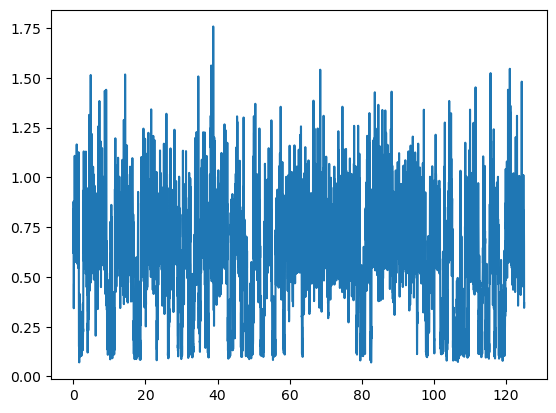

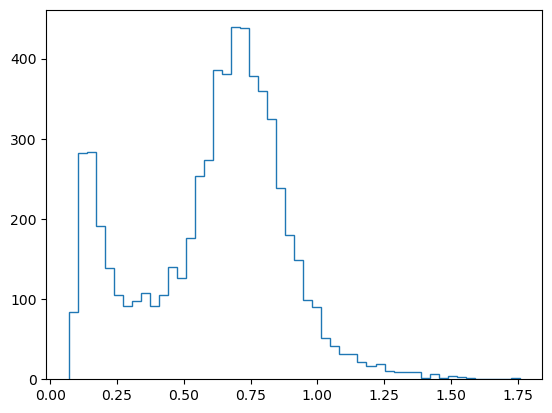

In [20]:
#CA_trj_sel=trj.topology.select("name CA")
#CA_xray_sel=xray_CA.topology.select("name CA")
rmsd = md.rmsd(trjCA,xray_CA)
plt.plot(time,rmsd)
plt.show()
plt.clf()

plt.hist(rmsd,histtype='step',bins=50)
plt.show()

<>:13: SyntaxWarning: invalid escape sequence '\p'
<>:14: SyntaxWarning: invalid escape sequence '\p'
<>:13: SyntaxWarning: invalid escape sequence '\p'
<>:14: SyntaxWarning: invalid escape sequence '\p'
C:\Users\f004q29\AppData\Local\Temp\ipykernel_13936\3077102990.py:13: SyntaxWarning: invalid escape sequence '\p'
  plt.xlabel('$\phi$', size=18)
C:\Users\f004q29\AppData\Local\Temp\ipykernel_13936\3077102990.py:14: SyntaxWarning: invalid escape sequence '\p'
  plt.ylabel('$\psi$', size=18)


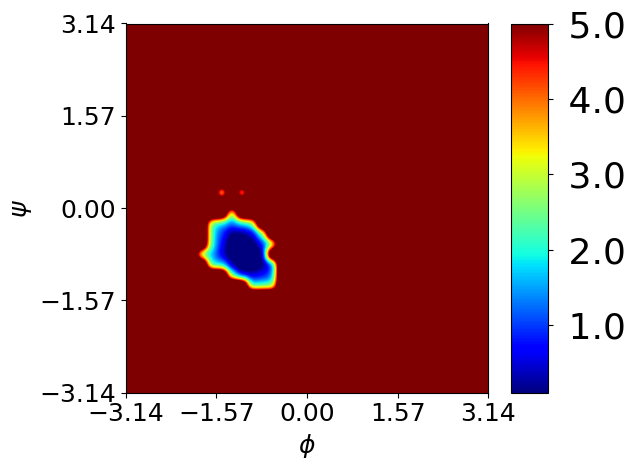

In [21]:
def plot_phipsi_FES_frames(res,frames):
 free_energy,xedges,yedges=np.histogram2d(dihedral_dict['psi'][res][frames],dihedral_dict['phi'][res][frames],36,[[-3.14,3.14],[-3.14,3.14]],density=True,weights=None)
 free_energy=np.log(np.flipud(free_energy)+.000001)
 T=300                                                                                                  
 kbT=T*0.008314/4.184 # kT in kcal/mol
 dG=-(kbT)*free_energy #Convert to kcal/mol
 im=plt.imshow(dG, interpolation='gaussian',extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],cmap='jet',aspect='auto')
 cbar_ticks=[0,1,2,3,4,5]
 cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'), aspect=10) # grab the Colorbar instance
 imaxes = plt.gca()                                                                                                 
 plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.xlabel('$\phi$', size=18)
 plt.ylabel('$\psi$', size=18)
 plt.tick_params(labelsize=18)
 plt.axes(cb.ax)
 plt.clim(vmin=0.1,vmax=5.0)
 plt.yticks(size='26')
 plt.tight_layout()
 plt.show()
 return


native_frames=np.where(rmsd<0.25)[0]
len(native_frames)
trj[native_frames].save_dcd(outdir+'native.dcd')

plot_phipsi_FES_frames(66,native_frames)


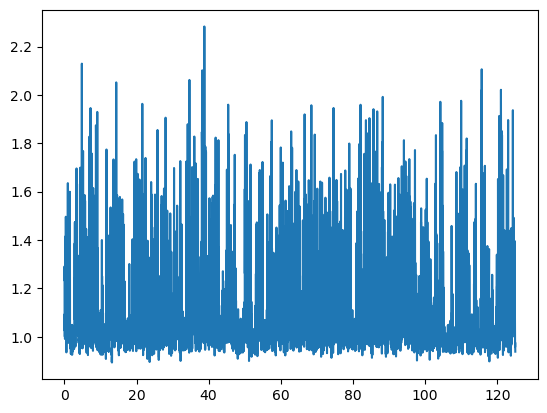

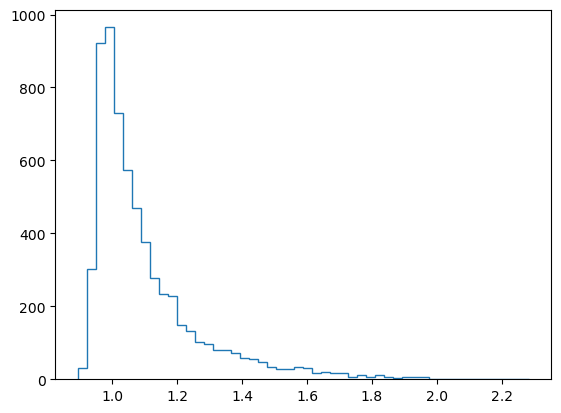

In [22]:
#Lets calculate the radius of gyration
rg=md.compute_rg(trj, masses=None)
plt.plot(time,rg)
plt.show()
plt.clf()

plt.hist(rg,histtype='step',bins=50)
plt.show()

In [23]:
import sklearn
from sklearn.decomposition import PCA

pca1 = PCA(n_components=2)
trj.superpose(trj, 0)
reduced_cartesian = pca1.fit_transform(trj.xyz.reshape(trj.n_frames, trj.n_atoms * 3))
print(reduced_cartesian.shape)

(6280, 2)


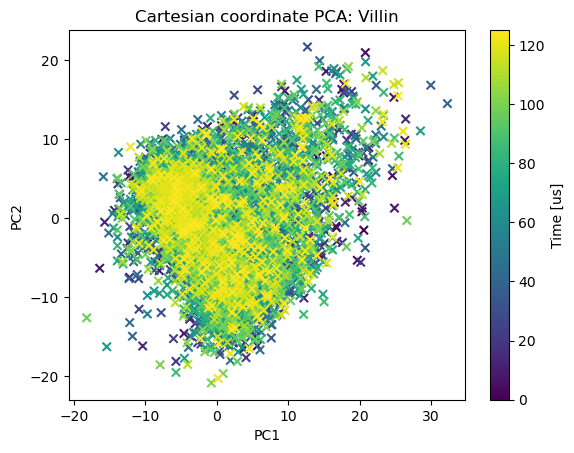

In [24]:
plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=time)
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA: Villin')
cbar = plt.colorbar()
cbar.set_label('Time [us]')

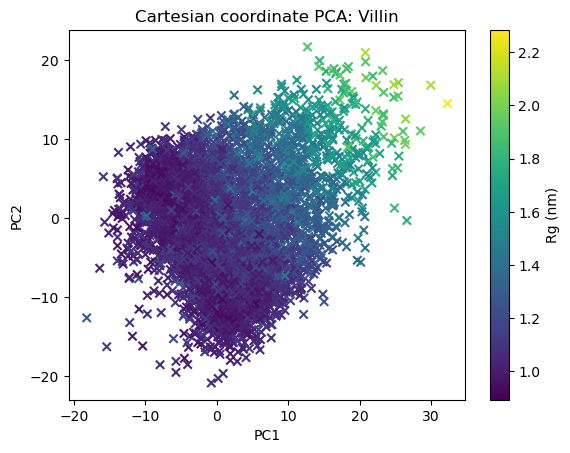

In [25]:
plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=rg)
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA: Villin')
cbar = plt.colorbar()
cbar.set_label('Rg (nm)')

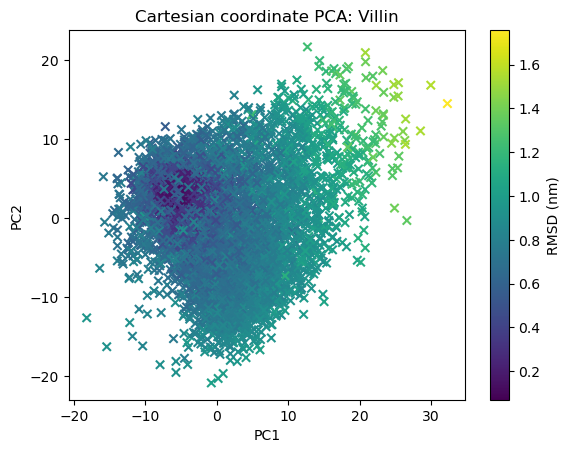

In [26]:
plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=rmsd)
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA: Villin')
cbar = plt.colorbar()
cbar.set_label('RMSD (nm)')

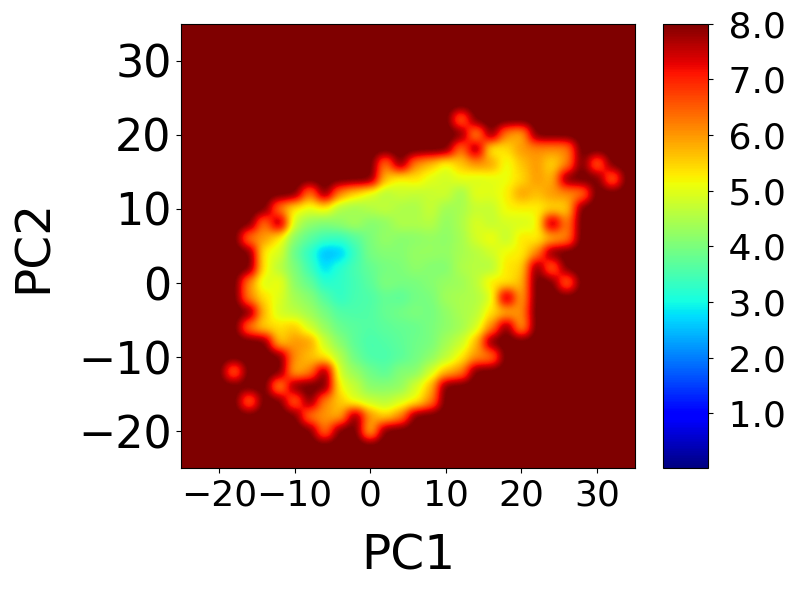

In [27]:
def free_energy(a, b, T, y0, ymax, x0, xmax):
    free_energy, xedges, yedges = np.histogram2d(
        a, b, 30, [[y0, ymax], [x0, xmax]], density=True, weights=None)
    free_energy = np.log(np.flipud(free_energy)+.000001)
    free_energy = -(0.001987*T)*free_energy
    return free_energy, xedges, yedges

PC1=reduced_cartesian[:, 0]
PC2=reduced_cartesian[:,1]

dG,xedges,yedges=free_energy(PC2, PC1, 300, -25, 35, -25, 35)

fig = plt.figure(figsize=(8, 6))
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2, 3, 4, 5,6,7,8]
plt.xlim(-25,35)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("PC2", size=35, labelpad=15)
plt.xlabel("PC1", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0.01, vmax=8.0)
plt.yticks(size='26')
plt.tight_layout()

*** Classroom Activitiy: Lets plot the free energy as a function of RMSD***

In [28]:
#Lets Plot Free Energies as a function of RMSD and Rg

def free_energy1D(a,T,x0,xmax,bins):
    free_energy, xedges= np.histogram(
        a, bins, [x0, xmax], density=True, weights=None)
    xcenters= xedges[:-1] + np.diff(xedges)/2
    free_energy = np.log(free_energy+.0000001)
    free_energy = -(0.001987*T)*free_energy
    return free_energy, xcenters



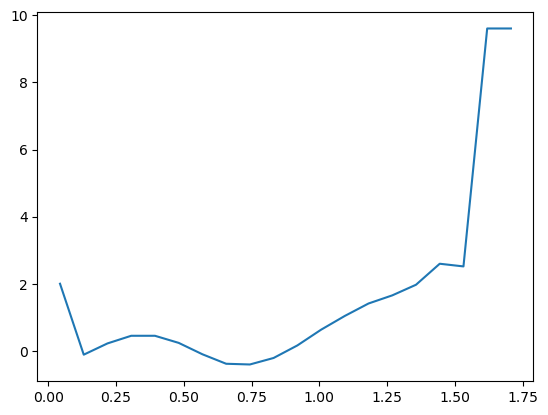

In [29]:
dG_RMSD,xedges=free_energy1D(rmsd,300,0,1.75,20)

plt.plot(xedges,dG_RMSD)

In [30]:
#Possible Homework Prompt:
#Visualize the lowest free energy basin
basin_frames=np.where((rmsd>0.60) & (rmsd<0.80))[0]
len(basin_frames)
trj[basin_frames].save_dcd(outdir+'rmsd.dgmin.basin.dcd')

*** Classroom Activitiy: Lets plot the free energy as a function of Rg vs. RMSD***

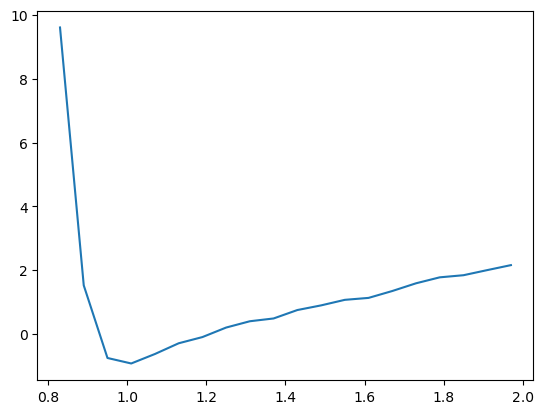

In [31]:
dG_rg,xedges=free_energy1D(rg,300,0.8,2.0,20)

plt.plot(xedges,dG_rg)

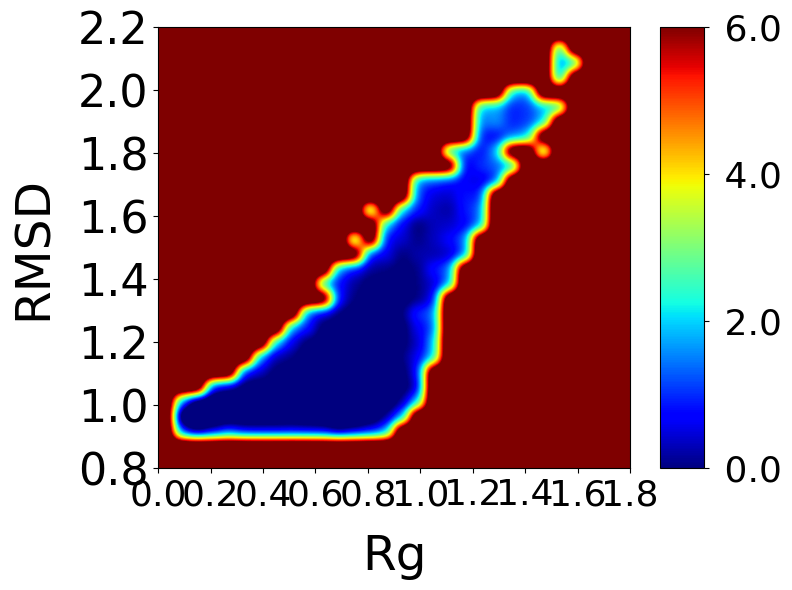

In [32]:
dG,xedges,yedges=free_energy(rg, rmsd, 300, 0.8, 2.2, 0, 1.8)

fig = plt.figure(figsize=(8, 6))
#im = plt.imshow(dG, extent=[
#                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0,2,4,6]
#plt.xlim(-25,35)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("RMSD", size=35, labelpad=15)
plt.xlabel("Rg", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0, vmax=6.0)
plt.yticks(size='26')
plt.tight_layout()

In [33]:
#Lets Make a Contact Map
contact_maps = []
contact_distances = []

for i in range(0, 34):
    contact_map = []
    contact_distance = []
    for j in range(0, 34):
        if i == j:
            contacts = 0
        else:
            dist = md.compute_contacts(trj, [[i, j]])
            array = np.asarray(dist[0]).astype(float)
            distance = np.average(array)
            contact_distance.append(distance)
            contact = np.where(array < 0.5, 1, 0)
            contacts = np.average(contact)
        contact_map.append(contacts)
    contact_maps.append(contact_map)
    contact_distances.append(contact_distance)
final_map = np.asarray(contact_maps).astype(float)
final_distance = np.asarray(contact_distances).astype(float)


In [34]:
#Lets Make Nice Contact Map Labels
sequence=[]
for residue in trj.topology.residues:
    sequence.append(residue)
#Lets Zero Out some of the Labels 
n=2
for i in range (0,len(sequence)): 
  if (i % n !=0):
   sequence[i]=''

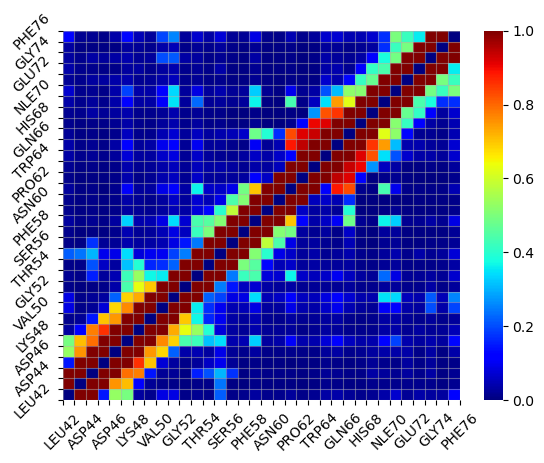

In [35]:
ax = sns.heatmap(final_map, vmin=0.0, vmax=1.0,cmap='jet')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,35))
ax.set_yticks(range(0,35))
ax.set_xticklabels(sequence[:35],rotation=45)
ax.set_yticklabels(sequence[:35],rotation=45)
plt.show()

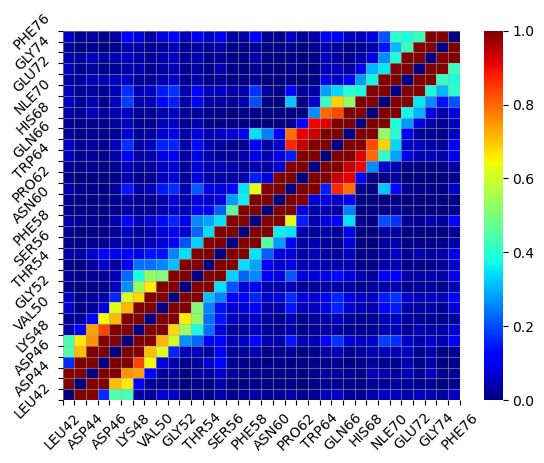

In [36]:
#Lets Make a Contact Map of the low dG Basin 
contact_maps = []
contact_distances = []

for i in range(0, 34):
    contact_map = []
    contact_distance = []
    for j in range(0, 34):
        if i == j:
            contacts = 0
        else:
            dist = md.compute_contacts(trj[basin_frames], [[i, j]])
            array = np.asarray(dist[0]).astype(float)
            distance = np.average(array)
            contact_distance.append(distance)
            contact = np.where(array < 0.5, 1, 0)
            contacts = np.average(contact)
        contact_map.append(contacts)
    contact_maps.append(contact_map)
    contact_distances.append(contact_distance)
final_map = np.asarray(contact_maps).astype(float)
final_distance = np.asarray(contact_distances).astype(float)

ax = sns.heatmap(final_map, vmin=0.0, vmax=1.0,cmap='jet')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,35))
ax.set_yticks(range(0,35))
ax.set_xticklabels(sequence[:35],rotation=45)
ax.set_yticklabels(sequence[:35],rotation=45)
plt.show()

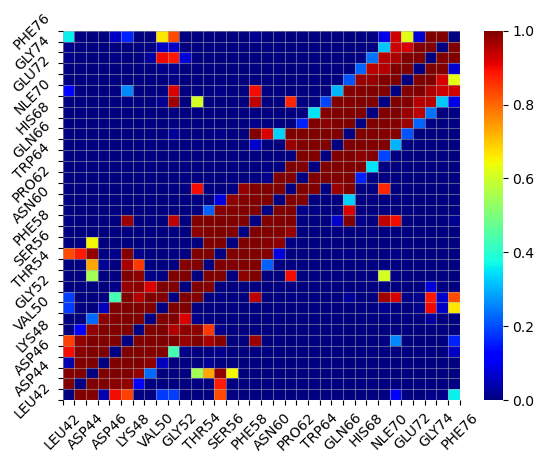

In [37]:
#Lets Make a Contact Map of the native frames
contact_maps = []
contact_distances = []

for i in range(0, 34):
    contact_map = []
    contact_distance = []
    for j in range(0, 34):
        if i == j:
            contacts = 0
        else:
            dist = md.compute_contacts(trj[native_frames], [[i, j]])
            array = np.asarray(dist[0]).astype(float)
            distance = np.average(array)
            contact_distance.append(distance)
            contact = np.where(array < 0.5, 1, 0)
            contacts = np.average(contact)
        contact_map.append(contacts)
    contact_maps.append(contact_map)
    contact_distances.append(contact_distance)
final_map = np.asarray(contact_maps).astype(float)
final_distance = np.asarray(contact_distances).astype(float)

ax = sns.heatmap(final_map, vmin=0.0, vmax=1.0,cmap='jet')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,35))
ax.set_yticks(range(0,35))
ax.set_xticklabels(sequence[:35],rotation=45)
ax.set_yticklabels(sequence[:35],rotation=45)
plt.show()

In [38]:
def circular_mean(angle):
    return np.arctan2(np.sum(np.sin(angle)),np.sum(np.cos(angle)))


def circular_corr(angle1,angle2):
    cmean1=circular_mean(angle1)
    cmean2=circular_mean(angle2)
    numerator=(np.sum(np.sin(angle1-cmean1)*np.sin(angle2-cmean2)))
    denom=((np.sum(np.sin(angle1-cmean1)**2)*np.sum(np.sin(angle2-cmean2)**2))**.5)
    ccor=numerator/denom
    return ccor

In [39]:
# Make correlation contact map
correlation_maps = []
for i in range(43, 76):
    cor_map = []
    for j in range(43, 76):
        phi=dihedral_dict['phi'][i]
        psi=dihedral_dict['psi'][j]
        ccor=circular_corr(psi,phi)
        cor_map.append(ccor)
    correlation_maps.append(cor_map)
final_cor_map = np.asarray(correlation_maps).astype(float)
np.shape(final_map)

(34, 34)

In [40]:
sequence=[]
for residue in trj.topology.residues:
    sequence.append(residue)
len(sequence)
seq_trunc=sequence[1:34]
#Lets Zero Out some of the Labels 
n=2
for i in range (0,33): 
  if (i % n !=0):
   seq_trunc[i]=''

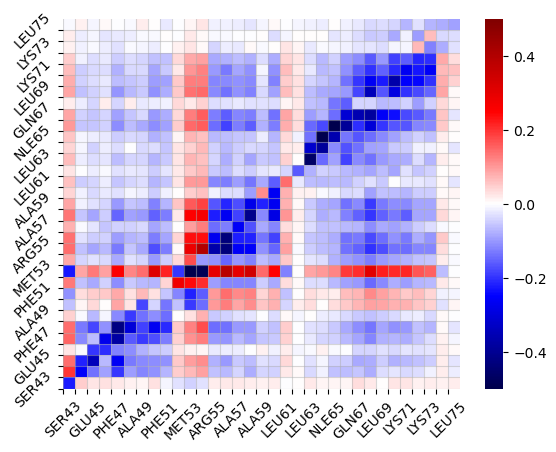

In [41]:
mask = np.zeros_like(final_map)
zeros=np.where((final_map<0.10) & (final_map>-0.10))
mask[zeros] = True
ax = sns.heatmap(final_cor_map, vmin=-0.5, vmax=0.5,cmap='seismic')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,33))
ax.set_yticks(range(0,33))
ax.set_xticklabels(seq_trunc,rotation=45)
ax.set_yticklabels(seq_trunc,rotation=45)
plt.show()

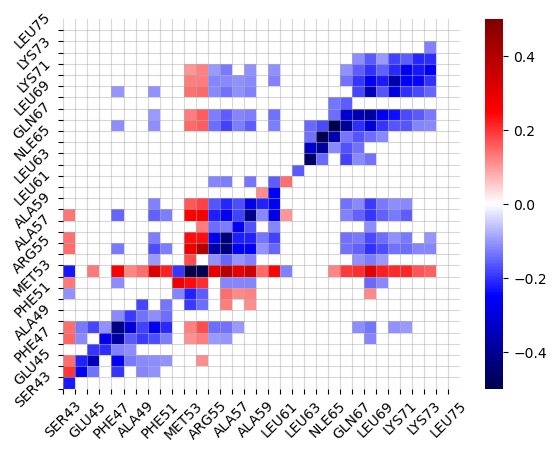

In [42]:
mask = np.zeros_like(final_cor_map)
zeros=np.where((final_cor_map<0.10) & (final_cor_map>-0.10))
mask[zeros] = True
ax = sns.heatmap(final_cor_map,mask=mask, vmin=-0.5, vmax=0.5,cmap='seismic')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,33))
ax.set_yticks(range(0,33))
ax.set_xticklabels(seq_trunc,rotation=45)
ax.set_yticklabels(seq_trunc,rotation=45)
plt.show()

We want to try to Reproduce the Free Energy Plot From
https://www.science.org/doi/full/10.1126/science.1208351

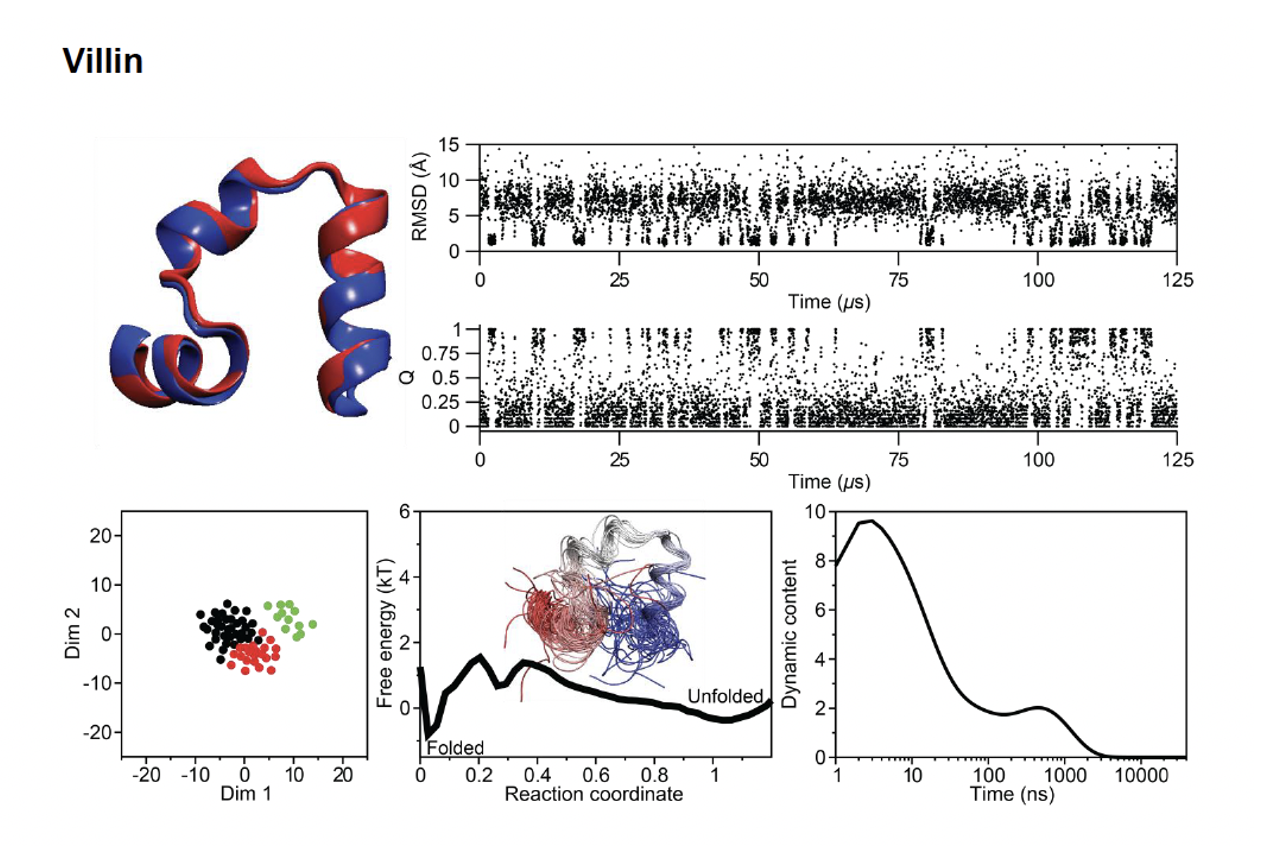

First we need to determine the native contacts and calculate Q

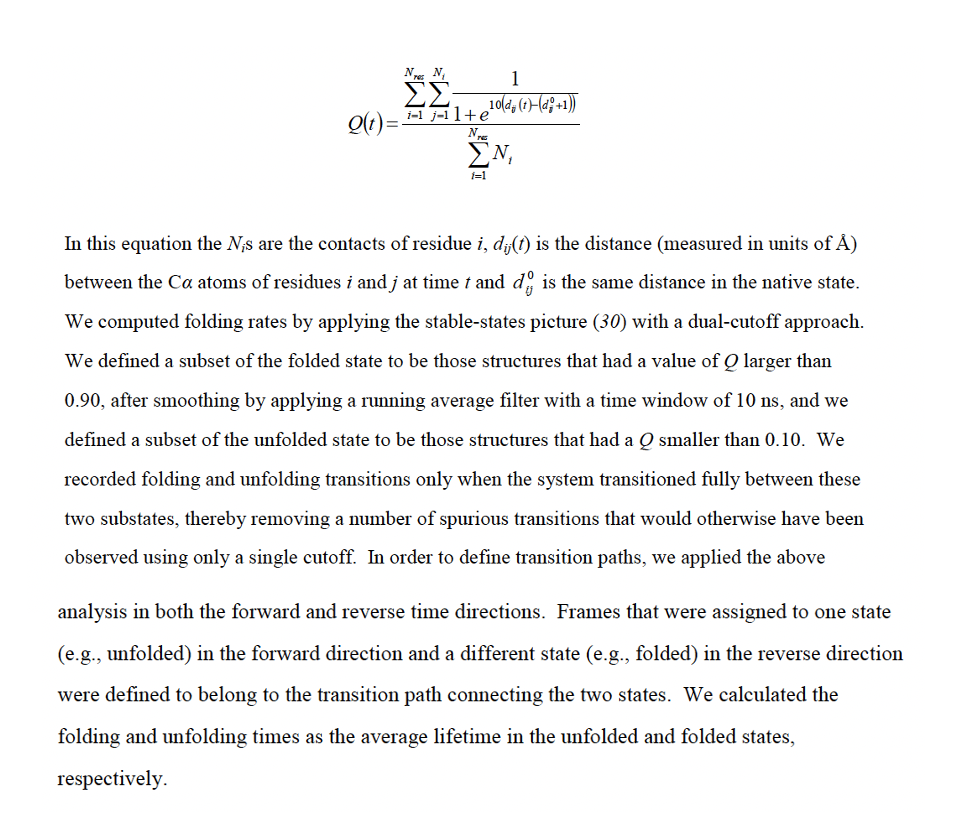

In [43]:
#Lets Make a 1D array that contains all native distances pairs:
xray_CA

<mdtraj.Trajectory with 1 frames, 35 atoms, 35 residues, and unitcells at 0x162ce8a14c0>

In [44]:
native_distance_matrix1D=[]
for i in range(0,34):
 for j in range(0, 34):
  if(abs(i-j)>7):
   #print(i,j)
   dist=md.compute_distances(xray_CA,[[i,j]])[0][0]
   native_distance_matrix1D.append(dist)

#Convert to Angstrom
native_distance_matrix1D=np.asarray(native_distance_matrix1D)*10


In [45]:
Native_Contacts=np.where(native_distance_matrix1D<10)
Native_Contact_Distances=native_distance_matrix1D[Native_Contacts]
np.shape(Native_Contact_Distances)

(148,)

In [46]:
traj_CA_distance_matrix1D=[]
for i in range(0,34):
 for j in range(0, 34):
  if(abs(i-j)>7):
   dist=md.compute_distances(trjCA,[[i,j]])[:,0]
   traj_CA_distance_matrix1D.append(dist)

#Convert to Angstrom
traj_CA_distance_matrix1D=np.asarray(traj_CA_distance_matrix1D)*10
Traj_Native_Contact_Distances=traj_CA_distance_matrix1D[Native_Contacts]


In [47]:
np.shape(Traj_Native_Contact_Distances)

(148, 6280)

In [48]:
for i in range(0,len(Native_Contact_Distances)):
  print(Native_Contact_Distances[i],Traj_Native_Contact_Distances[i])

9.288557 [16.155031 10.791452 12.989177 ...  9.819974 13.44309  12.631355]
9.985726 [11.540491 20.317595 20.025805 ... 11.637041 11.133914  9.529006]
9.704253 [11.477718 20.877588 17.621155 ...  9.078924  8.659006  7.693935]
9.60349 [ 9.620813 13.511494 10.39926  ... 10.133906  9.546892  7.720747]
7.0967283 [ 8.358078  16.181501   9.917504  ...  8.583042   6.1711082  5.1262226]
7.0852814 [10.051856  18.739012  13.814268  ...  5.561247   5.1992693  5.3546863]
9.99271 [13.804028  21.581156  13.504515  ...  6.8650303  7.900141   8.60963  ]
9.574567 [12.595353  12.5168705 11.052504  ... 10.495369   8.90573    9.204168 ]
8.303897 [11.918608  15.800192   9.9505415 ...  9.353915   6.660173   7.861574 ]
9.653462 [13.711605  17.694164  13.798973  ...  6.8816047  7.4799404  8.898192 ]
9.792494 [17.497013 20.938164 14.502391 ...  9.647299 10.491154 12.31331 ]
9.633482 [12.349012 14.908751 11.635593 ...  9.368454  8.254533  8.578752]
7.2052145 [18.622604 19.704548 15.620064 ... 10.816223 11.794368

In [49]:
#Expand Native Distance Matrix so that its the same number of frames as the trajectory
Native_Contact_Distances_nframes=np.zeros(np.shape(Traj_Native_Contact_Distances))
for i in range(0,len(Native_Contact_Distances)):
 Native_Contact_Distances_nframes[i]=Native_Contact_Distances[i]

In [50]:
np.shape(Native_Contacts_Xray_Dist)

NameError: name 'Native_Contacts_Xray_Dist' is not defined

In [51]:
for i in range(0,46):
    print(Native_Contacts_Xray_Dist[i],Native_Contacts_Trj_Dist[i])

NameError: name 'Native_Contacts_Xray_Dist' is not defined

In [52]:
Xray_Distance_Expand=np.zeros(np.shape(Native_Contacts_Trj_Dist))
for i in range(0,len(Native_Contacts_Trj_Dist)):
    Xray_Distance_Expand[i,:]=Native_Contacts_Xray_Dist[i]
    
Xray_Distance_Expand

NameError: name 'Native_Contacts_Trj_Dist' is not defined

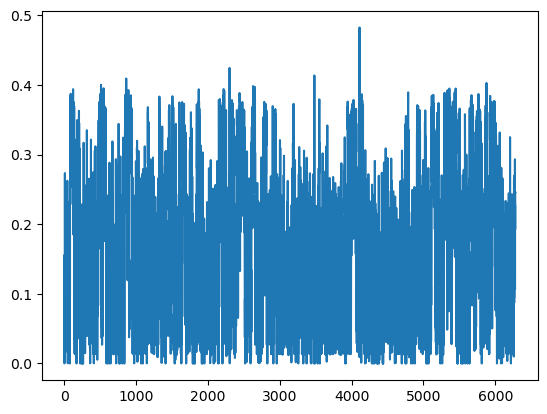

(array([1.087e+03, 1.503e+03, 9.610e+02, 6.850e+02, 4.700e+02, 4.940e+02,
        5.690e+02, 4.810e+02, 2.900e+01, 1.000e+00]),
 array([1.28075769e-25, 4.82478970e-02, 9.64957939e-02, 1.44743691e-01,
        1.92991588e-01, 2.41239485e-01, 2.89487382e-01, 3.37735279e-01,
        3.85983176e-01, 4.34231073e-01, 4.82478970e-01]),
 [<matplotlib.patches.Polygon at 0x162ce9e6180>])

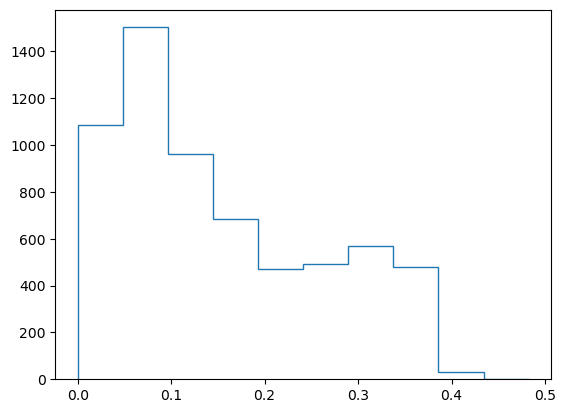

In [53]:
Q=1/(1+np.exp(10*(Traj_Native_Contact_Distances-(Native_Contact_Distances_nframes+1))))

Q_sum=np.sum(Q,axis=0)
Q_sum=np.sum(Q,axis=0)
Q=Q_sum/len(Native_Contact_Distances)
plt.plot(Q)
plt.show()
plt.clf()
plt.hist(Q,histtype='step')

In [54]:
#Now Lets Consider a "Native Portion of the Trajectory"
native_frames

array([  79,   80,   81, ..., 6007, 6009, 6011], dtype=int64)

In [55]:
native_distance_matrix1D=[]
for i in range(0,34):
 for j in range(0, 34):
  if(abs(i-j)>7):
   #print(i,j)
   dist=md.compute_distances(xray_CA,[[i,j]])[0][0]
   native_distance_matrix1D.append(dist)

#Convert to Angstrom
native_distance_matrix1D=np.asarray(native_distance_matrix1D)*10


In [56]:
np.shape(native_distance_matrix1D)

(702,)

In [57]:
np.shape(traj_CA_distance_matrix1D)

(702, 6280)

In [58]:
#Select Only the Frames with low RMSD from native state
trj_native_distances=traj_CA_distance_matrix1D[:,native_frames]
np.shape(trj_native_distances)

(702, 1016)

In [59]:
averages=np.average(trj_native_distances,axis=1)
Native_Contacts=np.where(averages<10.0)[0]
Native_Contacts

array([  5,  29,  30,  52,  53,  54,  55,  75,  76,  77,  98,  99, 120,
       123, 193, 196, 198, 211, 212, 215, 239, 240, 257, 258, 259, 260,
       275, 276, 277, 278, 279, 280, 296, 337, 341, 344, 500, 550, 557,
       569, 570, 635, 636, 684], dtype=int64)

In [60]:
Native_CA_Distances=native_distance_matrix1D[Native_Contacts]
Traj_CA_Distnaces=traj_CA_distance_matrix1D[Native_Contacts]
#Expand Native Distance Matrix so that its the same number of frames as the trajectory
Native_Contact_Distances_nframes=np.zeros(np.shape(Traj_CA_Distnaces))
for i in range(0,len(Native_CA_Distances)):
 Native_Contact_Distances_nframes[i]=Native_CA_Distances[i]

np.shape(Native_Contact_Distances_nframes)

(44, 6280)

In [61]:
for i in range(0,len(Native_CA_Distances)):
  print(Native_CA_Distances[i],Traj_CA_Distnaces[i])

9.985726 [11.540491 20.317595 20.025805 ... 11.637041 11.133914  9.529006]
10.452459 [ 9.374432 18.456451 13.714305 ... 11.399559  9.84092   8.788097]
9.704253 [11.477718 20.877588 17.621155 ...  9.078924  8.659006  7.693935]
9.60349 [ 9.620813 13.511494 10.39926  ... 10.133906  9.546892  7.720747]
7.0967283 [ 8.358078  16.181501   9.917504  ...  8.583042   6.1711082  5.1262226]
7.0852814 [10.051856  18.739012  13.814268  ...  5.561247   5.1992693  5.3546863]
9.99271 [13.804028  21.581156  13.504515  ...  6.8650303  7.900141   8.60963  ]
9.574567 [12.595353  12.5168705 11.052504  ... 10.495369   8.90573    9.204168 ]
8.303897 [11.918608  15.800192   9.9505415 ...  9.353915   6.660173   7.861574 ]
9.653462 [13.711605  17.694164  13.798973  ...  6.8816047  7.4799404  8.898192 ]
9.633482 [12.349012 14.908751 11.635593 ...  9.368454  8.254533  8.578752]
10.225195 [14.985344 16.675589 15.238585 ...  8.309675  8.071144  8.658443]
6.8318415 [12.484558  14.192814  12.563656  ...  5.9191756  5.

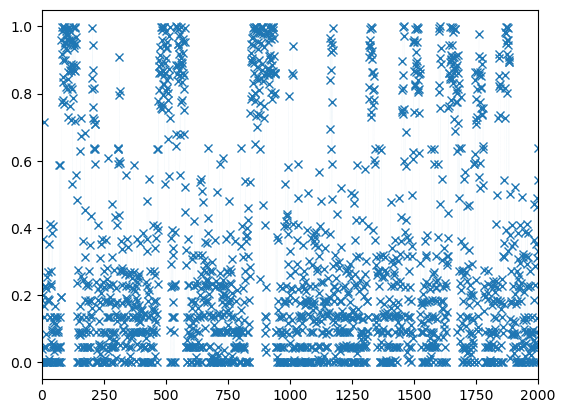

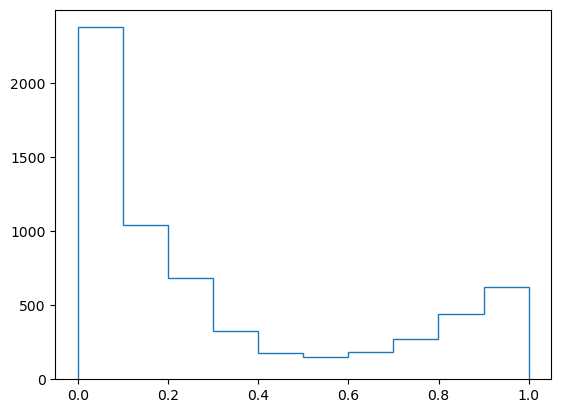

In [62]:
Q=1/(1+np.exp(10*(Traj_CA_Distnaces-(Native_Contact_Distances_nframes+1))))
Q_sum=np.sum(Q,axis=0)
Q_sum=np.sum(Q,axis=0)
Q=Q_sum/len(Native_CA_Distances)
plt.plot(Q,marker='x',linewidth=.01)
plt.xlim(0,2000)
plt.show()
plt.clf()
plt.hist(Q,histtype='step')
plt.show()

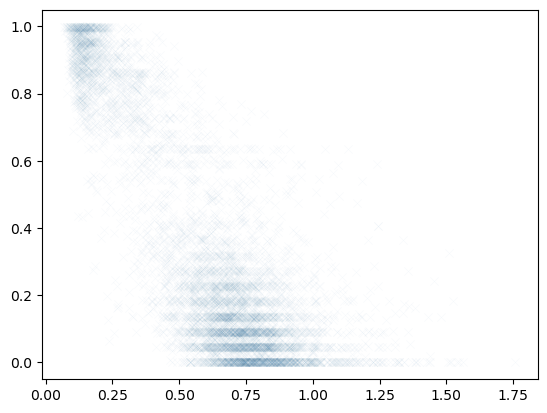

In [63]:
#Plot Q and a Histogram
plt.scatter(rmsd,Q,marker='x',linewidth=.01)

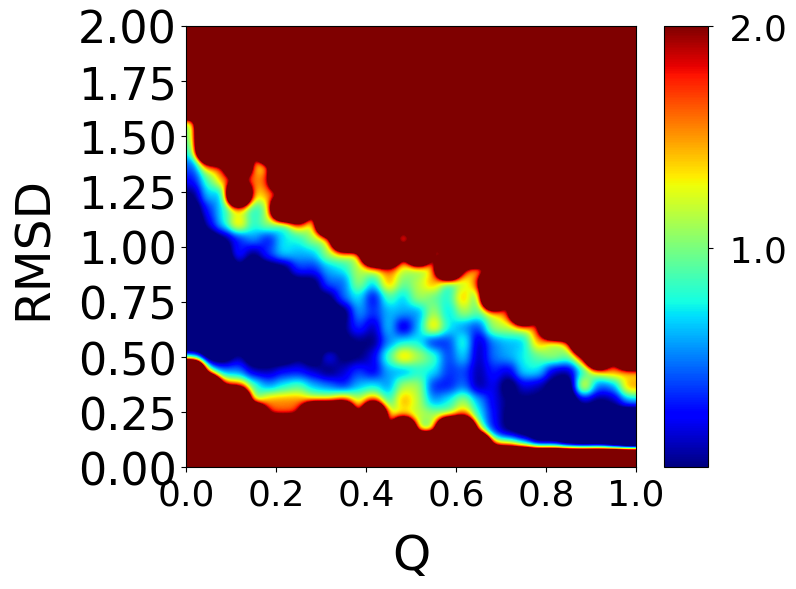

In [64]:
dG,xedges,yedges=free_energy(rmsd, Q, 300, 0, 2.0, 0, 1)

fig = plt.figure(figsize=(8, 6))
#im = plt.imshow(dG, extent=[
#                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0,1,2]
#plt.xlim(-25,35)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("RMSD", size=35, labelpad=15)
plt.xlabel("Q", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0.01, vmax=2.0)
plt.yticks(size='26')
plt.tight_layout()

<>:5: SyntaxWarning: invalid escape sequence '\D'
<>:5: SyntaxWarning: invalid escape sequence '\D'
C:\Users\f004q29\AppData\Local\Temp\ipykernel_13936\81337726.py:5: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel("$\Delta$G",size=15)


Text(0, 0.5, '$\\Delta$G')

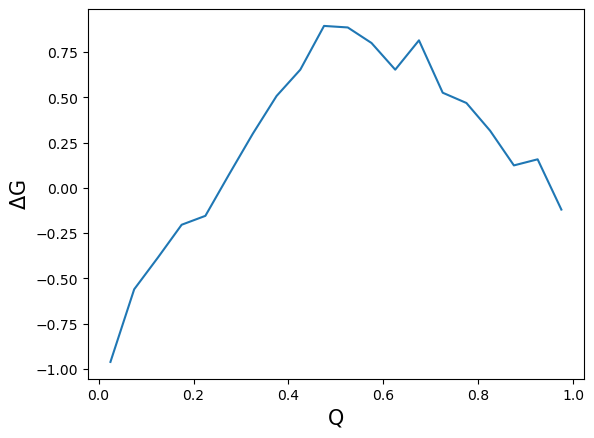

In [65]:
dG_Q,xedges=free_energy1D(Q,300,0,1,20)

plt.plot(xedges,dG_Q)
plt.xlabel("Q",size=15)
plt.ylabel("$\Delta$G",size=15)

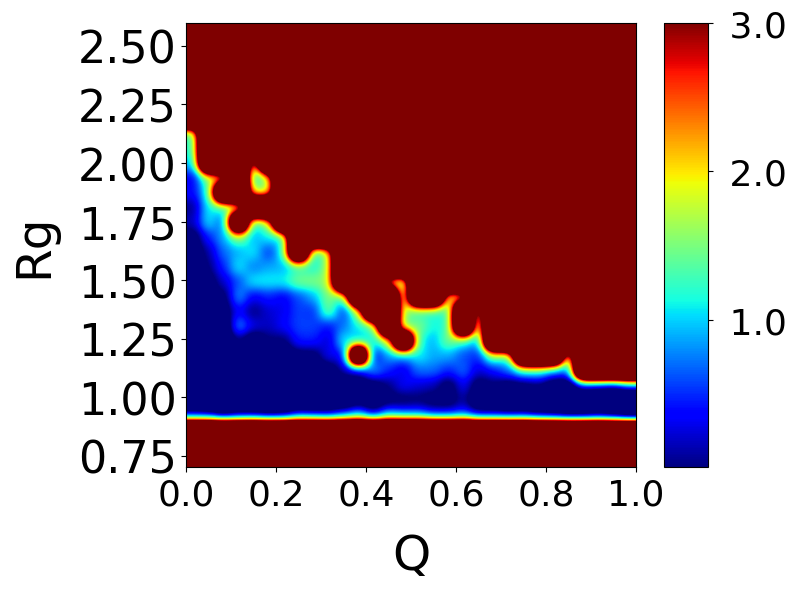

In [66]:
dG,xedges,yedges=free_energy(rg, Q, 300, 0.7, 2.6, 0, 1)

fig = plt.figure(figsize=(8, 6))
#im = plt.imshow(dG, extent=[
#                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2,3]
#plt.xlim(-25,35)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("Rg", size=35, labelpad=15)
plt.xlabel("Q", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0.01, vmax=3.0)
plt.yticks(size='26')
plt.tight_layout()

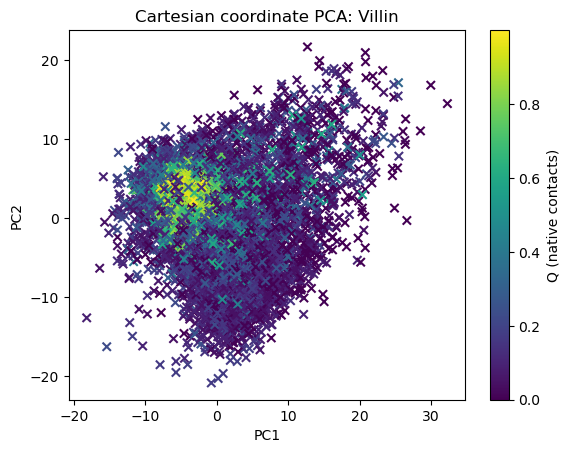

In [67]:
### plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=Q)
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA: Villin')
cbar = plt.colorbar()
cbar.set_label('Q (native contacts)')

In [68]:
#Now Lets Filter Our Distances based on only the "Native Portion of the Trajectory" and recompute Q
native_frames

array([  79,   80,   81, ..., 6007, 6009, 6011], dtype=int64)

In [69]:
#Select Only the Frames with low RMSD from native state for the native distances


In [70]:
#Filter the native distances to only include distances where the average value < 10A in the native frames 


In [71]:
#Check that we're comparing all the correct distances 


In [72]:
#Plot Q using only our native frames


In [73]:
#Lets Calculate Our Transition Paths using the Dual Cutoff Approach 

In [74]:
#Consider using a windowing function to smooth our vlaues of Q for Transition Path Calculations


In [75]:
import pandas as pd

In [177]:
#Q_df=pd.DataFrame(Q)
Q_df=pd.DataFrame()
Q_df['Q']=Q
Q_smooth=Q_df.rolling(window=3).mean()['Q']

In [178]:
Q_smooth

0            NaN
1            NaN
2       0.075251
3       0.013571
4       0.080604
          ...   
6275    0.426255
6276    0.268719
6277    0.222744
6278    0.422122
6279    0.594809
Name: Q, Length: 6280, dtype: float64

In [179]:
125000/len(Q) #ns/frame

19.904458598726116

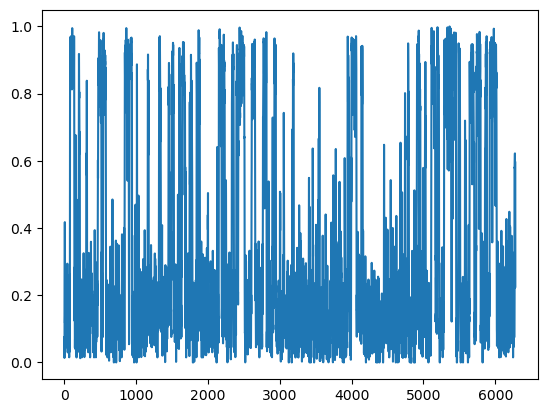

In [180]:
plt.plot(list(range(len(Q_smooth))),Q_smooth)

In [181]:
Q_alt=Q_smooth.loc[(Q_smooth>0.9)|(Q_smooth<0.1)]
indices=Q_alt.index.values.tolist()
for idx,i in enumerate(indices[1:]):
    if Q_alt.iloc[Q_alt.index==indices[idx+1]].values[0]>0.9 and Q_alt.iloc[Q_alt.index==indices[idx]].values[0]<0.1:
        print(indices[idx],indices[idx+1], 'disorder to order')
    if Q_alt.iloc[Q_alt.index==indices[idx+1]].values[0]<0.1 and Q_alt.iloc[Q_alt.index==indices[idx]].values[0]>0.9:
        print(indices[idx],indices[idx+1], 'order to disorder')
    

74 83 disorder to order
138 147 order to disorder
191 205 disorder to order
205 221 order to disorder
460 478 disorder to order
515 519 order to disorder
535 543 disorder to order
571 586 order to disorder
837 844 disorder to order
893 901 order to disorder
903 908 disorder to order
937 945 order to disorder
1159 1166 disorder to order
1166 1183 order to disorder
1308 1323 disorder to order
1332 1353 order to disorder
1490 1504 disorder to order
1516 1533 order to disorder
1597 1602 disorder to order
1603 1622 order to disorder
1631 1645 disorder to order
1666 1696 order to disorder
1759 1764 disorder to order
1764 1788 order to disorder
1860 1870 disorder to order
1884 1891 order to disorder
2149 2153 disorder to order
2188 2202 order to disorder
2217 2220 disorder to order
2223 2238 order to disorder
2328 2341 disorder to order
2355 2364 order to disorder
2391 2402 disorder to order
2504 2514 order to disorder
2600 2615 disorder to order
2654 2668 order to disorder
2756 2774 disorder

Text(0, 0.5, 'Q')

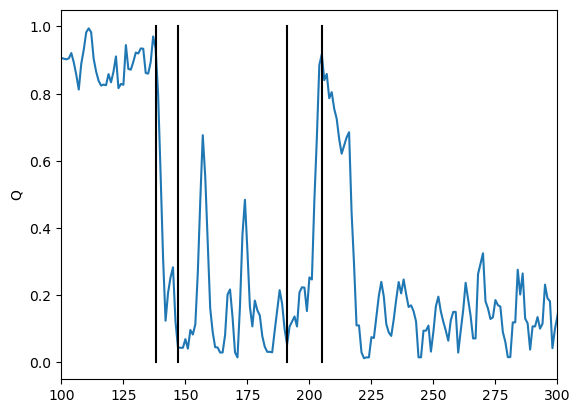

In [182]:
plt.plot(list(range(len(Q_smooth))),Q_smooth)
plt.plot([138,138],[0,1],color='black')
plt.plot([147,147],[0,1],color='black')
plt.plot([191,191],[0,1],color='black')
plt.plot([205,205],[0,1],color='black')
plt.xlim([100,300])
plt.ylabel('Q')
#higlight a transition identified above, between the black lines

In [170]:
def get_helix_frac(my_dssp):
    return list(my_dssp).count('H')/(len(my_dssp))

Text(0, 0.5, 'Helix fraction')

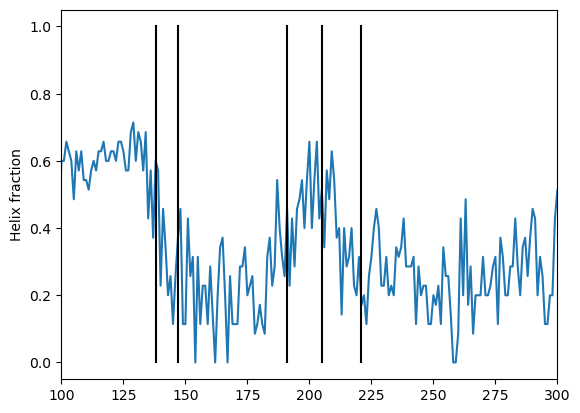

In [186]:
plt.plot(list(range(len(dssp))),[get_helix_frac(i) for i in dssp])
plt.plot([138,138],[0,1],color='black')
plt.plot([147,147],[0,1],color='black')
plt.plot([191,191],[0,1],color='black')
plt.plot([205,205],[0,1],color='black')
plt.plot([221,221],[0,1],color='black')
plt.xlim([100,300])
plt.ylabel('Helix fraction')
#show the helix fraction throughout the transition
# It can be seen that it increases (decreases) as the protein orderd (disorders)

Text(0, 0.5, 'helix fraction')

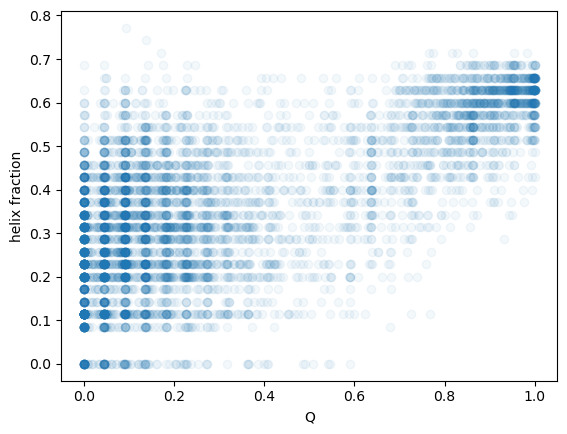

In [174]:
plt.scatter(Q,[get_helix_frac(i) for i in dssp],alpha=0.05)
plt.xlabel('Q')
plt.ylabel('helix fraction')
#There are two major 'blobs' disordered and ordered

In [202]:
helix_fraction_disordered=np.mean([get_helix_frac(i) for idx,i in enumerate(dssp) if Q_smooth.iloc[idx]<0.1])
helix_fraction_ordered=np.mean([get_helix_frac(i) for idx,i in enumerate(dssp) if Q_smooth.iloc[idx]>0.9])

print(f'The average helical content for disordered states (Q<0.1) is {round(helix_fraction_disordered,3)} and for ordered states (Q>0.9) is {round(helix_fraction_ordered,3)}')

The average helical content for disordered states (Q<0.1) is 0.266 and for ordered states (Q>0.9) is 0.606


In [201]:
helix_fraction_disordered=np.mean([get_helix_frac(i) for idx,i in enumerate(dssp) if Q_smooth.iloc[idx]<0.5])
helix_fraction_ordered=np.mean([get_helix_frac(i) for idx,i in enumerate(dssp) if Q_smooth.iloc[idx]>0.5])
#I use 0.5 as a cut off here because it looks like a clear separation point on the graph above
print(f'The average helical content for disordered states (Q<0.5) is {round(helix_fraction_disordered,3)} and for ordered states (Q>0.5) is {round(helix_fraction_ordered,3)}')

The average helical content for disordered states (Q<0.5) is 0.291 and for ordered states (Q>0.5) is 0.558
